#**Autonomous Financial News Analyzer & Stock Movement Predictor**

This project uses NLP and time-series modeling to:
- Analyze financial news sentiment using a BERT model
- Predict whether FAANG stocks will go Up or Down based on historical patterns

# Phase 1: News Sentiment Analyzer

Upload Both ZIP Files
* for more readability and usability

In [117]:
import zipfile
import os

# Unzip both files
with zipfile.ZipFile("/content/archive (2).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset1")

with zipfile.ZipFile("/content/archive (3).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset2")

# List files to verify
print("Dataset 1:", os.listdir("/content/dataset1"))
print("Dataset 2:", os.listdir("/content/dataset2"))

Dataset 1: ['FinancialPhraseBank', 'all-data.csv']
Dataset 2: ['raw_analyst_ratings.csv', 'raw_partner_headlines.csv', 'analyst_ratings_processed.csv']


Load CSV Files

In [118]:
import pandas as pd

# FinancialPhraseBank
phrasebank_df = pd.read_csv("/content/dataset1/all-data.csv", encoding='latin-1', header=None)
phrasebank_df.columns = ['Sentiment', 'Headline']

# Analyst ratings datasets
partner_headlines_df = pd.read_csv("/content/dataset2/raw_partner_headlines.csv")
ratings_df = pd.read_csv("/content/dataset2/analyst_ratings_processed.csv")

# Preview
phrasebank_df.head(), partner_headlines_df.head(), ratings_df.head()

(  Sentiment                                           Headline
 0   neutral  According to Gran , the company has no plans t...
 1   neutral  Technopolis plans to develop in stages an area...
 2  negative  The international electronic industry company ...
 3  positive  With the new production plant the company woul...
 4  positive  According to the company 's updated strategy f...,
    Unnamed: 0                                           headline  \
 0           2  Agilent Technologies Announces Pricing of $5……...   
 1           3  Agilent (A) Gears Up for Q2 Earnings: What's i...   
 2           4  J.P. Morgan Asset Management Announces Liquida...   
 3           5  Pershing Square Capital Management, L.P. Buys ...   
 4           6  Agilent Awards Trilogy Sciences with a Golden ...   
 
                                                  url  publisher  \
 0  http://www.gurufocus.com/news/1153187/agilent-...  GuruFocus   
 1  http://www.zacks.com/stock/news/931205/agilent...      Zack

Preprocessing

In [119]:
# STEP 1: Map text labels to numbers
label_map = {
    'positive': 1,
    'neutral': 0,
    'negative': 2 # changed from -1 to 2 as this is what BERT expects by default and -1 causes the error because the model can’t process negative label values
}
phrasebank_df['Label'] = phrasebank_df['Sentiment'].map(label_map)

In [120]:
#check if mapping failed(null values)
print(phrasebank_df.isnull().sum())

Sentiment    0
Headline     0
Label        0
dtype: int64


In [121]:
# STEP 2: Drop rows where mapping failed
phrasebank_df = phrasebank_df.dropna(subset=['Label'])

In [122]:
print(phrasebank_df.isnull().sum())

Sentiment    0
Headline     0
Label        0
dtype: int64


In [123]:
#check for duplicates
print( phrasebank_df.duplicated().sum())

6


In [124]:
# STEP 3: Drop duplicates again (to be safe)
phrasebank_df = phrasebank_df.drop_duplicates()

In [125]:
print( phrasebank_df.duplicated().sum())

0


In [126]:
# STEP 4: Final shape and class balance
print("Cleaned dataset shape:", phrasebank_df.shape)
print("\nLabel distribution:")
print(phrasebank_df['Label'].value_counts())

Cleaned dataset shape: (4840, 3)

Label distribution:
Label
0    2873
1    1363
2     604
Name: count, dtype: int64


In [127]:
#View sample
phrasebank_df.sample(5)

,Sentiment,Headline,Label
2875,neutral,Efore has decided to establish a company for e...,0
1334,neutral,Shares will be acquired in accordance with sec...,0
350,positive,Nokia - the world 's largest mobile phone manu...,1
2049,positive,The insurer anticipates its share in Nordea 's...,1
4354,negative,The number of salaried employees and group adm...,2


Preparing the Text Data for AI models

We’re going to convert raw text (headlines) into a format that a machine learning or deep learning model can understand which is called as tokenization.

In [128]:
# STEP 1: Install Hugging Face Transformers
!pip install transformers --quiet

In [129]:
# STEP 2: Load BERT Tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [130]:
# STEP 3: Tokenize the headlines
# Truncate headlines to max 32 tokens for speed
encodings = tokenizer(
    list(phrasebank_df['Headline']),
    truncation=True,
    padding=True,
    max_length=32,
    return_tensors="pt"
)

In [131]:
# Print an example
print("🔹 Original:", phrasebank_df['Headline'].iloc[0])
print("🔹 Tokenized IDs:", encodings['input_ids'][0])
print("🔹 Attention Mask:", encodings['attention_mask'][0])

🔹 Original: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
🔹 Tokenized IDs: tensor([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
         2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
         2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0,
            0,     0])
🔹 Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0])


Building the Sentiment Classification Model

In [132]:
# STEP 1: Import dependencies
from transformers import BertForSequenceClassification  #A special version of BERT made for predicting classes
from torch.optim import AdamW #Optimizer (helps BERT learn from mistakes)
from torch.utils.data import DataLoader, TensorDataset, random_split #Tools to group and split our data
import torch #pytorch to run and train model

In [133]:
# STEP 2: Prepare labels (convert from float to int)
labels = torch.tensor(phrasebank_df['Label'].astype(int).values)

In [134]:
# STEP 3: Create dataset for training
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

In [135]:
# STEP 4: Split into training and validation sets 80-20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [136]:
# STEP 5: DataLoader (sends data in batches)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  #Breaks data into small chunks of 16 rows (called batches) to make model	Easier and faster to learn and Mixes the rows randomly to avoid pattern bias
val_loader = DataLoader(val_dataset, batch_size=16)

In [137]:
# STEP 6: Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3) #Loads the pretrained BERT model and sets it to predict 3 classes (positive, neutral, negative)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #This step helps your model learn faster if you have a good engine (GPU). If not, it’ll still work — just slower.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [138]:
# STEP 7: Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5) #Sets the learning process for the model: small steps (lr = 2e-5 = 0.00002 ) to adjust and improve predictions

In [139]:
print("✅ Model ready!")

✅ Model ready!


Training Your Sentiment Classifier Model

In [140]:
from transformers import get_scheduler
from tqdm import tqdm

In [141]:
# STEP 1: Training setup
epochs = 3  # Number of full passes through the dataset
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [142]:
# STEP 2: Start training loop
model.train()  # Put model in training mode

for epoch in range(epochs):
    print(f"\n🔁 Epoch {epoch+1}/{epochs}")
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        batch = [item.to(device) for item in batch]  # Move data to GPU/CPU
        input_ids, attention_mask, labels = batch

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass (get predictions)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass (learn from mistakes)
        loss.backward()

        # Update model weights
        optimizer.step()
        lr_scheduler.step()

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

print("\n✅ Training complete!")


🔁 Epoch 1/3


Epoch 1: 100%|██████████| 242/242 [21:57<00:00,  5.44s/it, loss=0.562]



🔁 Epoch 2/3


Epoch 2: 100%|██████████| 242/242 [21:16<00:00,  5.27s/it, loss=0.0698]



🔁 Epoch 3/3


Epoch 3: 100%|██████████| 242/242 [21:02<00:00,  5.22s/it, loss=0.107]


✅ Training complete!


Evaluate the Model's Performance

In [143]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [144]:
# STEP 1: Set model to evaluation mode (no learning now)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [145]:
# STEP 2: Store predictions and labels
predictions = []
true_labels = []

In [146]:
# STEP 3: Turn off gradient calculation (saves memory)
with torch.no_grad():
    for batch in val_loader:
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch

        # Get model output
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class (highest score)
        preds = torch.argmax(logits, dim=1)

        # Store
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [147]:
# STEP 4: Classification report
print("🔍 Classification Report:\n")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Neutral', 'Positive']))

🔍 Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.86      0.88       602
     Neutral       0.75      0.82      0.79       251
    Positive       0.80      0.82      0.81       115

    accuracy                           0.85       968
   macro avg       0.82      0.83      0.83       968
weighted avg       0.85      0.85      0.85       968



In [148]:
# STEP 5: Confusion Matrix
print("\n🧩 Confusion Matrix:\n")
print(confusion_matrix(true_labels, predictions))


🧩 Confusion Matrix:

[[518  64  20]
 [ 41 207   3]
 [ 16   5  94]]


 Accuracy = How many times was the model correct overall?

 Precision = When the model predicted Positive, how often was it right?

 Recall = ut of all actual Positive headlines, how many did the model find?

 F1-Score = Combines Precision + Recall into one number

Visualizing the Results

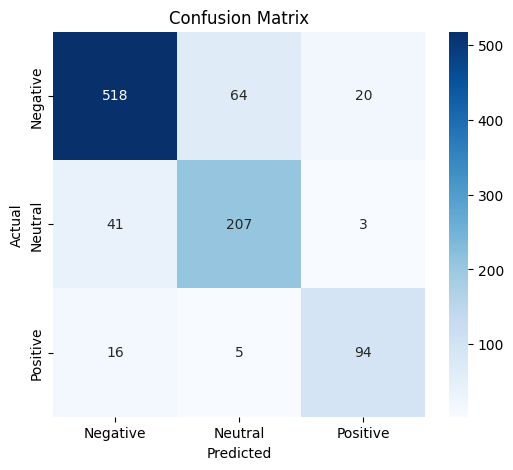

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Set class labels
class_names = ['Negative', 'Neutral', 'Positive']

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Save the Model

In [150]:
# Save model and tokenizer
model.save_pretrained("sentiment-finbert-model")
tokenizer.save_pretrained("sentiment-finbert-model")

('sentiment-finbert-model/tokenizer_config.json',
 'sentiment-finbert-model/special_tokens_map.json',
 'sentiment-finbert-model/vocab.txt',
 'sentiment-finbert-model/added_tokens.json')

In [151]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model
model = BertForSequenceClassification.from_pretrained("sentiment-finbert-model")
tokenizer = BertTokenizer.from_pretrained("sentiment-finbert-model")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

predict my own headline

In [152]:
# Your custom headline
text = "Tech stocks rally after strong earnings report"

# Tokenize it
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

# Map number back to label
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
print("🧠 Predicted Sentiment:", label_map[prediction])

🧠 Predicted Sentiment: Negative


# Phase 2: Stock Movement Predictor

**Predicting tomorrow's FAANG stocksbased on 5 year stock**

 5 Years of Daily Stock Data for AAPL

In [155]:
import yfinance as yf
import pandas as pd

# Download 5 years of AAPL daily stock data
aapl = yf.Ticker("AAPL")
aapl_df = aapl.history(period="5y", interval="1d", actions=False)

# Reset index so 'Date' becomes a normal column
aapl_df = aapl_df.reset_index()

# Preview
aapl_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-17 00:00:00-04:00,69.088306,69.636763,67.188124,68.629639,215250000
1,2020-04-20 00:00:00-04:00,67.452631,68.357819,67.185682,67.205093,130015200
2,2020-04-21 00:00:00-04:00,67.047346,67.282745,64.414277,65.127754,180991600
3,2020-04-22 00:00:00-04:00,66.399402,67.440497,66.057231,67.003677,116862400
4,2020-04-23 00:00:00-04:00,66.947853,68.374806,66.705174,66.744003,124814400


Create Up/Down Labels

In [156]:
# Create next day's close price
aapl_df['Next_Close'] = aapl_df['Close'].shift(-1)

# Drop last row (no next day available)
aapl_df.dropna(inplace=True)

# Create label: 1 if price goes up next day, else 0
aapl_df['Label'] = (aapl_df['Next_Close'] > aapl_df['Close']).astype(int)

# Preview the result
aapl_df[['Date', 'Close', 'Next_Close', 'Label']].head()

,Date,Close,Next_Close,Label
0,2020-04-17 00:00:00-04:00,68.629639,67.205093,0
1,2020-04-20 00:00:00-04:00,67.205093,65.127754,0
2,2020-04-21 00:00:00-04:00,65.127754,67.003677,1
3,2020-04-22 00:00:00-04:00,67.003677,66.744003,0
4,2020-04-23 00:00:00-04:00,66.744003,68.670898,1


Feature Engineering

In [157]:
# Daily return (percent change from previous close)
aapl_df['Pct_Change'] = aapl_df['Close'].pct_change() * 100

# Rolling moving averages
aapl_df['MA_5'] = aapl_df['Close'].rolling(window=5).mean()
aapl_df['MA_10'] = aapl_df['Close'].rolling(window=10).mean()

# Rolling volatility (standard deviation)
aapl_df['Volatility_5'] = aapl_df['Close'].rolling(window=5).std()

# Drop any rows with NaN (due to rolling windows)
aapl_df.dropna(inplace=True)

# Preview engineered features + label
aapl_df[['Date', 'Close', 'Pct_Change', 'MA_5', 'MA_10', 'Volatility_5', 'Label']].head()

,Date,Close,Pct_Change,MA_5,MA_10,Volatility_5,Label
9,2020-04-30 00:00:00-04:00,71.299110,2.109648,69.224194,68.083114,1.400762,0
10,2020-05-01 00:00:00-04:00,70.151237,-1.609940,69.520262,68.235274,1.410986,1
11,2020-05-04 00:00:00-04:00,71.143776,1.414855,70.005133,68.629142,1.481762,1
12,2020-05-05 00:00:00-04:00,72.211571,1.500897,70.926344,69.337524,0.955187,1
13,2020-05-06 00:00:00-04:00,72.956604,1.031737,71.552460,69.932816,1.072460,1


Train-Test Split + Model Training

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Select input features and target
features = ['Pct_Change', 'MA_5', 'MA_10', 'Volatility_5']
X = aapl_df[features]
y = aapl_df['Label']

# Step 2: Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 3: Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = model.predict(X_test)
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.95      0.60       104
           1       0.81      0.14      0.24       146

    accuracy                           0.48       250
   macro avg       0.62      0.55      0.42       250
weighted avg       0.66      0.48      0.39       250



**Predict stock movement for next day**

In [167]:
# Get the latest row (yesterday's data)
latest_data = aapl_df[features].iloc[-1:]

# Predict tomorrow's movement (April 17, 2025)
pred = model.predict(latest_data)[0]

# Output the prediction
movement = "🔼 UP" if pred == 1 else "🔽 DOWN"
print(f"📅 Predicted movement for AAPL on April 17, 2025: {movement}")

#model's confidence
probs = model.predict_proba(latest_data)[0]
print(f"🔍 Confidence - Down: {probs[0]:.2f}, Up: {probs[1]:.2f}")

📅 Predicted movement for AAPL on April 17, 2025: 🔽 DOWN
🔍 Confidence - Down: 0.74, Up: 0.26


 5 Years of Daily Stock Data for GOOGL

In [161]:
import yfinance as yf
import pandas as pd

# Download 5 years of GOOGL stock data
googl = yf.Ticker("GOOGL")
googl_df = googl.history(period="5y", interval="1d", actions=False)

# Reset index to bring Date as a column
googl_df = googl_df.reset_index()

# Preview
googl_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-17 00:00:00-04:00,63.780070,64.193096,62.998805,63.645714,51050000
1,2020-04-20 00:00:00-04:00,63.192383,63.537234,62.523082,62.757462,35292000
2,2020-04-21 00:00:00-04:00,61.839846,62.202610,59.963316,60.319614,49648000
3,2020-04-22 00:00:00-04:00,61.760227,63.689503,61.565658,62.621113,46296000
4,2020-04-23 00:00:00-04:00,62.985869,64.101040,62.726610,63.256077,34202000


Create Up/Down Labels

In [162]:
# Create next day's closing price
googl_df['Next_Close'] = googl_df['Close'].shift(-1)

# Drop last row (no next day data)
googl_df.dropna(inplace=True)

# Create label: 1 if stock goes up next day, else 0
googl_df['Label'] = (googl_df['Next_Close'] > googl_df['Close']).astype(int)

# Preview
googl_df[['Date', 'Close', 'Next_Close', 'Label']].head()

,Date,Close,Next_Close,Label
0,2020-04-17 00:00:00-04:00,63.645714,62.757462,0
1,2020-04-20 00:00:00-04:00,62.757462,60.319614,0
2,2020-04-21 00:00:00-04:00,60.319614,62.621113,1
3,2020-04-22 00:00:00-04:00,62.621113,63.256077,1
4,2020-04-23 00:00:00-04:00,63.256077,63.526283,1


Feature Engineering

In [163]:
# Daily return (% change from previous close)
googl_df['Pct_Change'] = googl_df['Close'].pct_change() * 100

# Moving averages
googl_df['MA_5'] = googl_df['Close'].rolling(window=5).mean()
googl_df['MA_10'] = googl_df['Close'].rolling(window=10).mean()

# Volatility over 5 days
googl_df['Volatility_5'] = googl_df['Close'].rolling(window=5).std()

# Drop NaNs from rolling calculations
googl_df.dropna(inplace=True)

# Preview engineered features
googl_df[['Date', 'Close', 'Pct_Change', 'MA_5', 'MA_10', 'Volatility_5', 'Label']].head()

,Date,Close,Pct_Change,MA_5,MA_10,Volatility_5,Label
9,2020-04-30 00:00:00-04:00,67.014610,0.336773,64.381495,63.450745,2.451483,0
10,2020-05-01 00:00:00-04:00,65.552597,-2.181634,64.786758,63.641434,2.442231,1
11,2020-05-04 00:00:00-04:00,65.830269,0.423586,65.304682,63.948714,2.302998,1
12,2020-05-05 00:00:00-04:00,67.130051,1.974444,66.463441,64.629758,0.721999,0
13,2020-05-06 00:00:00-04:00,66.951408,-0.266114,66.495787,65.062788,0.743569,1


Train-Test Split + Model Training

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select features and label
features = ['Pct_Change', 'MA_5', 'MA_10', 'Volatility_5']
X = googl_df[features]
y = googl_df['Label']

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train the model
model_googl = RandomForestClassifier(n_estimators=100, random_state=42)
model_googl.fit(X_train, y_train)

# Evaluate
y_pred = model_googl.predict(X_test)
print("✅ GOOGL Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ GOOGL Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.56      0.50       112
           1       0.55      0.43      0.49       138

    accuracy                           0.49       250
   macro avg       0.50      0.50      0.49       250
weighted avg       0.50      0.49      0.49       250



**Predict stock movement for next day**

In [168]:
# Get the latest available row of features
latest_data = googl_df[features].iloc[-1:]

# Predict movement
prediction = model_googl.predict(latest_data)[0]
movement = "🔼 UP" if prediction == 1 else "🔽 DOWN"
print(f"📅 GOOGL Prediction for April 17, 2025: {movement}")

# Show confidence (optional)
probabilities = model_googl.predict_proba(latest_data)[0]
print(f"🔍 Confidence - Down: {probabilities[0]:.2f}, Up: {probabilities[1]:.2f}")

📅 GOOGL Prediction for April 17, 2025: 🔽 DOWN
🔍 Confidence - Down: 0.51, Up: 0.49


5 Years of Daily Stock Data for AMZN

In [169]:
import yfinance as yf
import pandas as pd

# Download 5 years of AMZN stock data
amzn = yf.Ticker("AMZN")
amzn_df = amzn.history(period="5y", interval="1d", actions=False)

# Reset index to bring Date as a column
amzn_df = amzn_df.reset_index()

# Preview
amzn_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-17 00:00:00-04:00,118.616501,120.000000,115.801003,118.750000,158600000
1,2020-04-20 00:00:00-04:00,119.497498,122.249001,119.302498,119.680496,115414000
2,2020-04-21 00:00:00-04:00,120.830498,121.415497,113.983002,116.405998,149534000
3,2020-04-22 00:00:00-04:00,118.449997,119.699997,117.550003,118.174500,84244000
4,2020-04-23 00:00:00-04:00,119.999001,121.210999,119.103996,119.972504,101332000


Create Up/Down Labels

In [170]:
# Create next day's closing price
amzn_df['Next_Close'] = amzn_df['Close'].shift(-1)

# Drop the last row (no next day data)
amzn_df.dropna(inplace=True)

# Create label: 1 if price goes up next day, else 0
amzn_df['Label'] = (amzn_df['Next_Close'] > amzn_df['Close']).astype(int)

# Preview
amzn_df[['Date', 'Close', 'Next_Close', 'Label']].head()

,Date,Close,Next_Close,Label
0,2020-04-17 00:00:00-04:00,118.750000,119.680496,1
1,2020-04-20 00:00:00-04:00,119.680496,116.405998,0
2,2020-04-21 00:00:00-04:00,116.405998,118.174500,1
3,2020-04-22 00:00:00-04:00,118.174500,119.972504,1
4,2020-04-23 00:00:00-04:00,119.972504,120.511002,1


Feature Engineering

In [171]:
# Daily return (% change from previous close)
amzn_df['Pct_Change'] = amzn_df['Close'].pct_change() * 100

# Moving averages
amzn_df['MA_5'] = amzn_df['Close'].rolling(window=5).mean()
amzn_df['MA_10'] = amzn_df['Close'].rolling(window=10).mean()

# Volatility (standard deviation over 5 days)
amzn_df['Volatility_5'] = amzn_df['Close'].rolling(window=5).std()

# Drop rows with NaNs from rolling calculations
amzn_df.dropna(inplace=True)

# Preview engineered features
amzn_df[['Date', 'Close', 'Pct_Change', 'MA_5', 'MA_10', 'Volatility_5', 'Label']].head()

,Date,Close,Pct_Change,MA_5,MA_10,Volatility_5,Label
9,2020-04-30 00:00:00-04:00,123.699997,4.268957,119.470100,119.033400,2.928506,0
10,2020-05-01 00:00:00-04:00,114.302002,-7.597409,118.228300,118.588600,3.613171,1
11,2020-05-04 00:00:00-04:00,115.799500,1.310124,117.628200,118.200500,3.741378,1
12,2020-05-05 00:00:00-04:00,115.889999,0.078152,117.665399,118.148901,3.718317,1
13,2020-05-06 00:00:00-04:00,117.563004,1.443614,117.450900,118.087751,3.679092,1


Train-Test Split + Model Training

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
features = ['Pct_Change', 'MA_5', 'MA_10', 'Volatility_5']
X = amzn_df[features]
y = amzn_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train the model
model_amzn = RandomForestClassifier(n_estimators=100, random_state=42)
model_amzn.fit(X_train, y_train)

# Evaluate
y_pred = model_amzn.predict(X_test)
print("✅ AMZN Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ AMZN Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.94      0.66       124
           1       0.62      0.10      0.18       126

    accuracy                           0.52       250
   macro avg       0.56      0.52      0.42       250
weighted avg       0.56      0.52      0.42       250



**Predict stock movement for next day**

In [173]:
# Get the latest available feature row
latest_data = amzn_df[features].iloc[-1:]

# Predict movement for April 17, 2025
prediction = model_amzn.predict(latest_data)[0]
movement = "🔼 UP" if prediction == 1 else "🔽 DOWN"
print(f"📅 AMZN Prediction for April 17, 2025: {movement}")

# Confidence (optional)
probabilities = model_amzn.predict_proba(latest_data)[0]
print(f"🔍 Confidence - Down: {probabilities[0]:.2f}, Up: {probabilities[1]:.2f}")

📅 AMZN Prediction for April 17, 2025: 🔽 DOWN
🔍 Confidence - Down: 0.61, Up: 0.39


5 Years of Daily Stock Data for NFLX

In [174]:
import yfinance as yf
import pandas as pd

# Download 5 years of NFLX stock data
nflx = yf.Ticker("NFLX")
nflx_df = nflx.history(period="5y", interval="1d", actions=False)

# Reset index to bring Date as a column
nflx_df = nflx_df.reset_index()

# Preview
nflx_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-17 00:00:00-04:00,431.000000,432.000000,414.700012,422.959991,12616300
1,2020-04-20 00:00:00-04:00,435.170013,444.489990,430.559998,437.489990,12655800
2,2020-04-21 00:00:00-04:00,444.769989,447.000000,425.600006,433.829987,23177600
3,2020-04-22 00:00:00-04:00,429.730011,433.000000,413.000000,421.420013,21084800
4,2020-04-23 00:00:00-04:00,419.260010,438.410004,419.260010,426.700012,13952300


Create Up/Down Labels

In [175]:
# Create next day's closing price
nflx_df['Next_Close'] = nflx_df['Close'].shift(-1)

# Drop the last row (no next day available)
nflx_df.dropna(inplace=True)

# Create label: 1 if stock goes up next day, else 0
nflx_df['Label'] = (nflx_df['Next_Close'] > nflx_df['Close']).astype(int)

# Preview
nflx_df[['Date', 'Close', 'Next_Close', 'Label']].head()

,Date,Close,Next_Close,Label
0,2020-04-17 00:00:00-04:00,422.959991,437.489990,1
1,2020-04-20 00:00:00-04:00,437.489990,433.829987,0
2,2020-04-21 00:00:00-04:00,433.829987,421.420013,0
3,2020-04-22 00:00:00-04:00,421.420013,426.700012,1
4,2020-04-23 00:00:00-04:00,426.700012,424.989990,0


Feature Engineering

In [176]:
# Daily return (% change from previous close)
nflx_df['Pct_Change'] = nflx_df['Close'].pct_change() * 100

# Moving averages
nflx_df['MA_5'] = nflx_df['Close'].rolling(window=5).mean()
nflx_df['MA_10'] = nflx_df['Close'].rolling(window=10).mean()

# Volatility (standard deviation over 5 days)
nflx_df['Volatility_5'] = nflx_df['Close'].rolling(window=5).std()

# Drop NaNs from rolling calculations
nflx_df.dropna(inplace=True)

# Preview
nflx_df[['Date', 'Close', 'Pct_Change', 'MA_5', 'MA_10', 'Volatility_5', 'Label']].head()

,Date,Close,Pct_Change,MA_5,MA_10,Volatility_5,Label
9,2020-04-30 00:00:00-04:00,419.850006,1.932553,416.388000,422.434000,8.497579,0
10,2020-05-01 00:00:00-04:00,415.269989,-1.090870,414.444000,421.664999,7.021315,1
11,2020-05-04 00:00:00-04:00,428.149994,3.101598,415.797998,420.731000,9.052279,0
12,2020-05-05 00:00:00-04:00,424.679993,-0.810464,419.967999,419.816000,6.642420,1
13,2020-05-06 00:00:00-04:00,434.260010,2.255820,424.441998,421.100000,7.338450,1


Train-Test Split + Model Training

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and label
features = ['Pct_Change', 'MA_5', 'MA_10', 'Volatility_5']
X = nflx_df[features]
y = nflx_df['Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train Random Forest
model_nflx = RandomForestClassifier(n_estimators=100, random_state=42)
model_nflx.fit(X_train, y_train)

# Evaluate
y_pred = model_nflx.predict(X_test)
print("✅ NFLX Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ NFLX Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.79      0.57       117
           1       0.40      0.12      0.18       133

    accuracy                           0.44       250
   macro avg       0.42      0.46      0.38       250
weighted avg       0.42      0.44      0.36       250



**Predict stock movement for next day**

In [178]:
# Get the most recent row of features
latest_data = nflx_df[features].iloc[-1:]

# Predict tomorrow's movement
prediction = model_nflx.predict(latest_data)[0]
movement = "🔼 UP" if prediction == 1 else "🔽 DOWN"
print(f"📅 NFLX Prediction for April 17, 2025: {movement}")

# Confidence (optional)
probs = model_nflx.predict_proba(latest_data)[0]
print(f"🔍 Confidence - Down: {probs[0]:.2f}, Up: {probs[1]:.2f}")

📅 NFLX Prediction for April 17, 2025: 🔽 DOWN
🔍 Confidence - Down: 0.61, Up: 0.39


5 Years of Daily Stock Data for META(FACEBOOK)

In [179]:
import yfinance as yf
import pandas as pd

# Download 5 years of META stock data
meta = yf.Ticker("META")
meta_df = meta.history(period="5y", interval="1d", actions=False)

# Reset index to bring Date as a column
meta_df = meta_df.reset_index()

# Preview
meta_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-17 00:00:00-04:00,178.359395,179.434331,175.831316,178.399216,20974800
1,2020-04-20 00:00:00-04:00,176.577792,179.653293,175.940795,177.403900,16110700
2,2020-04-21 00:00:00-04:00,174.427917,174.557312,167.550328,169.998795,24850500
3,2020-04-22 00:00:00-04:00,177.612906,183.913215,177.304363,181.424942,33242000
4,2020-04-23 00:00:00-04:00,183.216489,186.172558,182.290843,184.261566,21426600


Create Up/Down Labels

In [180]:
# Create next day's closing price
meta_df['Next_Close'] = meta_df['Close'].shift(-1)

# Drop last row (no next day available)
meta_df.dropna(inplace=True)

# Create label: 1 if stock goes up next day, else 0
meta_df['Label'] = (meta_df['Next_Close'] > meta_df['Close']).astype(int)

# Preview
meta_df[['Date', 'Close', 'Next_Close', 'Label']].head()

,Date,Close,Next_Close,Label
0,2020-04-17 00:00:00-04:00,178.399216,177.403900,0
1,2020-04-20 00:00:00-04:00,177.403900,169.998795,0
2,2020-04-21 00:00:00-04:00,169.998795,181.424942,1
3,2020-04-22 00:00:00-04:00,181.424942,184.261566,1
4,2020-04-23 00:00:00-04:00,184.261566,189.178421,1


 Feature Engineering

In [181]:
# Daily return (% change from previous close)
meta_df['Pct_Change'] = meta_df['Close'].pct_change() * 100

# Moving averages
meta_df['MA_5'] = meta_df['Close'].rolling(window=5).mean()
meta_df['MA_10'] = meta_df['Close'].rolling(window=10).mean()

# Volatility (5-day std)
meta_df['Volatility_5'] = meta_df['Close'].rolling(window=5).std()

# Drop rows with NaNs from rolling calculations
meta_df.dropna(inplace=True)

# Preview
meta_df[['Date', 'Close', 'Pct_Change', 'MA_5', 'MA_10', 'Volatility_5', 'Label']].head()

,Date,Close,Pct_Change,MA_5,MA_10,Volatility_5,Label
9,2020-04-30 00:00:00-04:00,203.749725,5.417369,190.975934,184.636809,8.220589,0
10,2020-05-01 00:00:00-04:00,201.321182,-1.191925,193.404486,186.929005,9.281920,1
11,2020-05-04 00:00:00-04:00,204.297134,1.478211,196.939822,189.618329,9.417401,1
12,2020-05-05 00:00:00-04:00,206.098663,0.881818,201.749158,193.228316,5.033338,1
13,2020-05-06 00:00:00-04:00,207.492096,0.676100,204.591760,195.835031,2.354528,1


Train-Test Split + Model Training

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
features = ['Pct_Change', 'MA_5', 'MA_10', 'Volatility_5']
X = meta_df[features]
y = meta_df['Label']

# Split data (no shuffle, to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train the model
model_meta = RandomForestClassifier(n_estimators=100, random_state=42)
model_meta.fit(X_train, y_train)

# Evaluate
y_pred = model_meta.predict(X_test)
print("✅ META Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ META Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.90      0.62       116
           1       0.57      0.12      0.20       134

    accuracy                           0.48       250
   macro avg       0.52      0.51      0.41       250
weighted avg       0.52      0.48      0.39       250



**Predict stock movement for next day**

In [183]:
# Use the most recent row of features
latest_data = meta_df[features].iloc[-1:]

# Predict tomorrow's movement
prediction = model_meta.predict(latest_data)[0]
movement = "🔼 UP" if prediction == 1 else "🔽 DOWN"
print(f"📅 META Prediction for April 17, 2025: {movement}")

# Confidence (optional)
probs = model_meta.predict_proba(latest_data)[0]
print(f"🔍 Confidence - Down: {probs[0]:.2f}, Up: {probs[1]:.2f}")

📅 META Prediction for April 17, 2025: 🔽 DOWN
🔍 Confidence - Down: 0.71, Up: 0.29


# Results & Visualizations

**Visualize tomorrow's faang stock**

<ipython-input-187-4b844e0c05c2>:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-187-4b844e0c05c2>:29: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


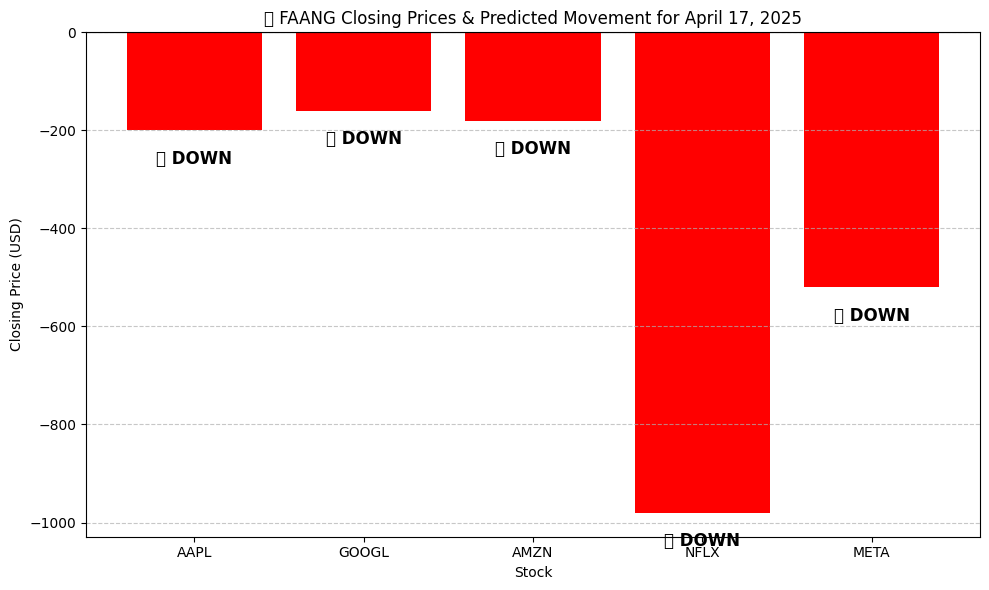

In [187]:
import matplotlib.pyplot as plt

# Example: Replace with your actual data
stocks = ['AAPL', 'GOOGL', 'AMZN', 'NFLX', 'META']
closing_prices = [200, 160, 180, 980, 520]  # latest close values
predictions = [0, 0, 0, 0, 0]  # replace with actual predictions: 1 = Up, 0 = Down

# Convert closing prices to negative if predicted down
adjusted_prices = [price if pred == 1 else -price for price, pred in zip(closing_prices, predictions)]
colors = ['green' if pred == 1 else 'red' for pred in predictions]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(stocks, adjusted_prices, color=colors)

# Add text labels
for bar, pred in zip(bars, predictions):
    label = '🔼 UP' if pred == 1 else '🔽 DOWN'
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (20 if height > 0 else -40), label,
             ha='center', va='bottom' if height > 0 else 'top', fontsize=12, fontweight='bold')

# Style
plt.axhline(0, color='black', linewidth=0.8)
plt.title("📊 FAANG Closing Prices & Predicted Movement for April 17, 2025")
plt.ylabel("Closing Price (USD)")
plt.xlabel("Stock")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**FAANG Last 30 Days Trend**

<ipython-input-185-57e3a55ccf89>:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


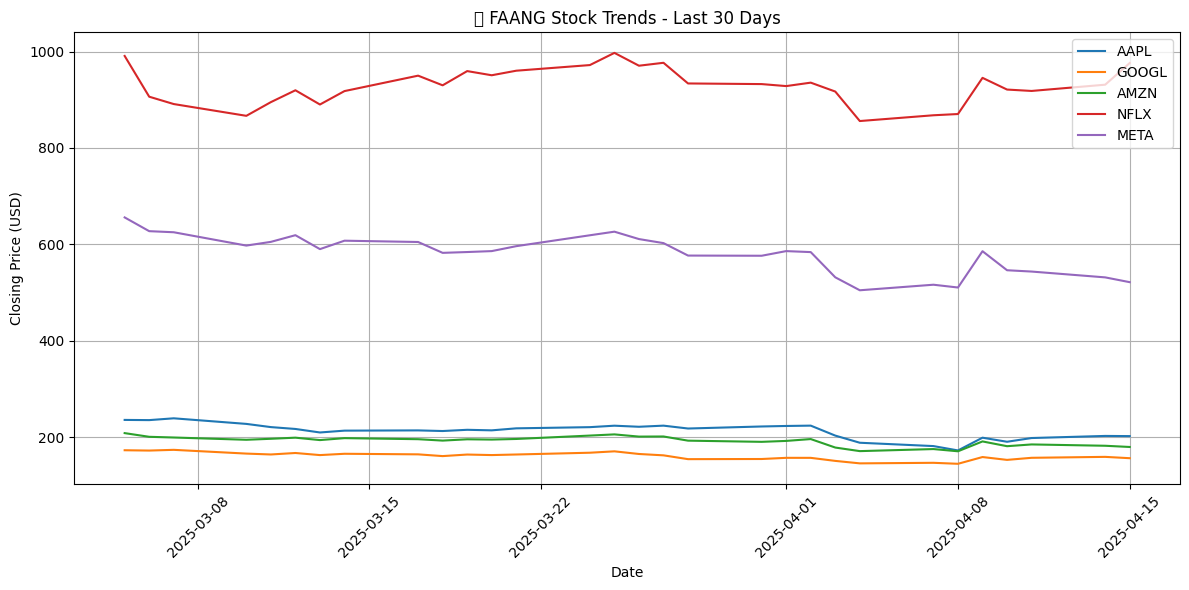

In [185]:
import matplotlib.pyplot as plt

# Get last 30 days of close prices for each FAANG stock
window = 30
aapl_line = aapl_df[['Date', 'Close']].tail(window)
googl_line = googl_df[['Date', 'Close']].tail(window)
amzn_line = amzn_df[['Date', 'Close']].tail(window)
nflx_line = nflx_df[['Date', 'Close']].tail(window)
meta_line = meta_df[['Date', 'Close']].tail(window)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(aapl_line['Date'], aapl_line['Close'], label='AAPL')
plt.plot(googl_line['Date'], googl_line['Close'], label='GOOGL')
plt.plot(amzn_line['Date'], amzn_line['Close'], label='AMZN')
plt.plot(nflx_line['Date'], nflx_line['Close'], label='NFLX')
plt.plot(meta_line['Date'], meta_line['Close'], label='META')

# Style
plt.title("📈 FAANG Stock Trends - Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ Summary:
- Built and trained a financial sentiment classifier using BERT
- Engineered time-series features from 5 years of FAANG stock data
- Trained separate models for each stock to predict Up/Down movement
- Visualized predictions for April 17, 2025

🧠 Skills demonstrated: NLP, time-series modeling, yfinance, matplotlib, Random Forest